# Forest Fire Simulation & Prediction

This notebook simulates forest fire spread using a cellular automaton model and applies machine learning to predict burnt areas. The best model is selected using TOPSIS (Technique for Order of Preference by Similarity to Ideal Solution) analysis.

## 1. Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors
import os


## 2. Define Cell States

In [ ]:
EMPTY = 0   # burnt / empty
TREE = 1    # healthy tree
FIRE = 2    # burning tree


## 3. Simulation Functions

In [ ]:
def initialize_forest(grid_size, p_tree, p_fire):
    forest = np.zeros((grid_size, grid_size), dtype=int)

    for i in range(grid_size):
        for j in range(grid_size):
            if np.random.rand() < p_tree:
                forest[i, j] = TREE
                if np.random.rand() < p_fire:
                    forest[i, j] = FIRE
    return forest


In [ ]:
def spread_fire(forest, p_spread):
    new_forest = forest.copy()
    rows, cols = forest.shape

    for i in range(rows):
        for j in range(cols):
            if forest[i, j] == FIRE:
                new_forest[i, j] = EMPTY

                for di, dj in [(-1,0),(1,0),(0,-1),(0,1)]:
                    ni, nj = i + di, j + dj
                    if 0 <= ni < rows and 0 <= nj < cols:
                        if forest[ni, nj] == TREE:
                            if np.random.rand() < p_spread:
                                new_forest[ni, nj] = FIRE
    return new_forest


In [ ]:
def run_simulation(grid_size, p_tree, p_fire, p_spread, max_steps=100):
    forest = initialize_forest(grid_size, p_tree, p_fire)
    history = []
    steps = 0

    while FIRE in forest and steps < max_steps:
        history.append(forest.copy())
        forest = spread_fire(forest, p_spread)
        steps += 1

    burnt_area = np.sum(forest == EMPTY) / (grid_size ** 2)
    return history, forest, burnt_area * 100, steps


## 4. Visualization Functions

In [ ]:
cmap = colors.ListedColormap(["black", "green", "red"])
bounds = [0, 1, 2, 3]
norm = colors.BoundaryNorm(bounds, cmap.N)


In [ ]:
def get_peak_fire_frame(history):
    fire_counts = [np.sum(frame == FIRE) for frame in history]
    peak_index = np.argmax(fire_counts)
    return history[peak_index], peak_index, fire_counts[peak_index]


In [ ]:
def plot_forest_as_trees(forest):
    plt.figure(figsize=(6,6))

    tree_y, tree_x = np.where(forest == TREE)
    fire_y, fire_x = np.where(forest == FIRE)
    empty_y, empty_x = np.where(forest == EMPTY)

    plt.scatter(tree_x, tree_y, c="green", marker="^", s=30, label="Tree")
    plt.scatter(fire_x, fire_y, c="red", marker="o", s=50, label="Fire")
    plt.scatter(empty_x, empty_y, c="black", marker=".", s=10, label="Burnt")

    plt.legend(loc="upper right")
    plt.gca().invert_yaxis()
    plt.axis("off")
    plt.title("Forest Fire Spread (Tree Representation)")
    plt.show()


## 5. Run Example Simulation

Burnt Area: 31.36%
Fire Duration: 9 steps
Peak Fire Cells: 17 at step 1


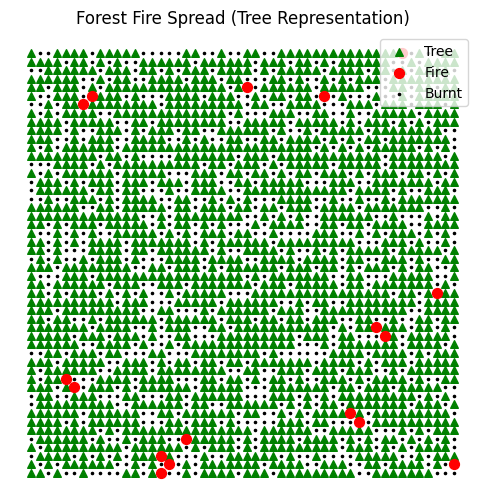

In [ ]:
history, final_forest, burnt, duration = run_simulation(
    grid_size=50,
    p_tree=0.7,
    p_fire=0.01,
    p_spread=0.4
)

peak_frame, peak_step, peak_fire = get_peak_fire_frame(history)

print(f"Burnt Area: {burnt:.2f}%")
print(f"Fire Duration: {duration} steps")
print(f"Peak Fire Cells: {peak_fire} at step {peak_step}")

plot_forest_as_trees(peak_frame)


## 6. Generate Training Dataset

Generate 1000 simulation samples with varying parameters to train machine learning models.

In [ ]:
GRID_SIZE_RANGE = (30, 80)
P_TREE_RANGE = (0.4, 0.9)
P_FIRE_RANGE = (0.001, 0.05)
P_SPREAD_RANGE = (0.1, 0.9)

def generate_one_sample():
    grid_size = np.random.randint(*GRID_SIZE_RANGE)
    p_tree = np.random.uniform(*P_TREE_RANGE)
    p_fire = np.random.uniform(*P_FIRE_RANGE)
    p_spread = np.random.uniform(*P_SPREAD_RANGE)

    _, _, burnt, duration = run_simulation(
        grid_size, p_tree, p_fire, p_spread
    )

    return [grid_size, p_tree, p_fire, p_spread, burnt, duration]


In [ ]:
data = [generate_one_sample() for _ in range(1000)]

columns = [
    "grid_size",
    "tree_density",
    "initial_fire_prob",
    "spread_probability",
    "burnt_area_percent",
    "fire_duration"
]

df = pd.DataFrame(data, columns=columns)


In [ ]:
os.makedirs("data", exist_ok=True)
df.to_csv("data/forest_fire_simulation_data.csv", index=False)


## 7. Load Dataset

In [ ]:
df = pd.read_csv("data/forest_fire_simulation_data.csv")

X = df[
    ["grid_size", "tree_density", "initial_fire_prob", "spread_probability"]
]
y = df["burnt_area_percent"]


## 8. Prepare Machine Learning Pipeline

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return {
        "R2": r2_score(y_test, y_pred),
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred))
    }


In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR

models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "Decision Tree": DecisionTreeRegressor(random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
    "SVR": SVR()
}


## 9. Train and Evaluate Models

Train multiple regression models and evaluate their performance using R², MAE, and RMSE metrics.

In [ ]:
results = []

for name, model in models.items():
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results.append([name, metrics["R2"], metrics["MAE"], metrics["RMSE"]])

results_df = pd.DataFrame(
    results, columns=["Model", "R2 Score", "MAE", "RMSE"]
).sort_values(by="R2 Score", ascending=False)

results_df


,Model,R2 Score,MAE,RMSE
4,Random Forest,0.963061,2.921934,4.352079
5,Gradient Boosting,0.949315,3.682117,5.097945
3,Decision Tree,0.903641,4.032535,7.029099
0,Linear Regression,0.616720,11.746653,14.018827
1,Ridge Regression,0.584066,12.070861,14.603809
2,Lasso Regression,0.492798,13.050152,16.126658
6,SVR,-0.002318,18.146582,22.670258


## 10. Analyze Best Model (Before TOPSIS)

In [ ]:
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]
best_model.fit(X_train, y_train)

print("Best Model:", best_model_name)


Best Model: Random Forest


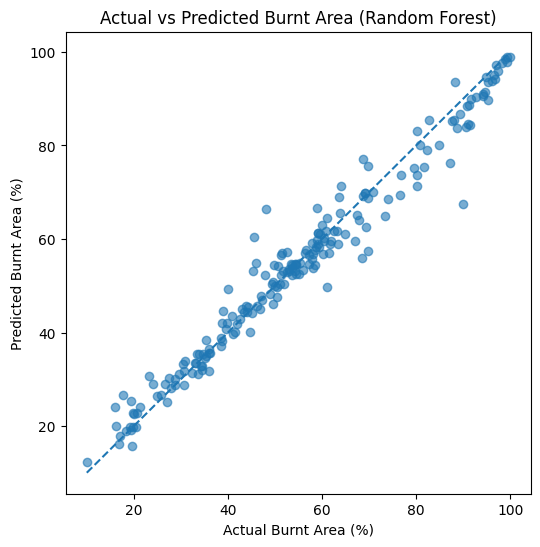

In [ ]:
y_pred = best_model.predict(X_test)

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot(
    [y_test.min(), y_test.max()],
    [y_test.min(), y_test.max()],
    linestyle="--"
)
plt.xlabel("Actual Burnt Area (%)")
plt.ylabel("Predicted Burnt Area (%)")
plt.title(f"Actual vs Predicted Burnt Area ({best_model_name})")
plt.show()


In [ ]:
if hasattr(best_model, "feature_importances_"):
    importance_df = pd.DataFrame({
        "Feature": X.columns,
        "Importance": best_model.feature_importances_
    }).sort_values(by="Importance", ascending=False)

    importance_df


## 11. TOPSIS Model Selection

Use TOPSIS (Technique for Order of Preference by Similarity to Ideal Solution) to rank models based on multiple criteria:
- **R² Score** (maximize)
- **MAE** (minimize)
- **RMSE** (minimize)

Weights: 0.4, 0.3, 0.3 respectively

### 11.1 Install TOPSIS Package

In [ ]:
!pip install Topsis-Prigya-102313061


### 11.2 View Model Results

In [ ]:
results_df


,Model,R2 Score,MAE,RMSE
4,Random Forest,0.963061,2.921934,4.352079
5,Gradient Boosting,0.949315,3.682117,5.097945
3,Decision Tree,0.903641,4.032535,7.029099
0,Linear Regression,0.616720,11.746653,14.018827
1,Ridge Regression,0.584066,12.070861,14.603809
2,Lasso Regression,0.492798,13.050152,16.126658
6,SVR,-0.002318,18.146582,22.670258


### 11.3 Prepare TOPSIS Input

In [ ]:
topsis_df = results_df[["Model", "R2 Score", "MAE", "RMSE"]]
topsis_df.to_csv("topsis_input.csv", index=False)


### 11.4 Verify TOPSIS Installation

In [ ]:
!pip show Topsis-Prigya-102313061


Name: Topsis-Prigya-102313061
Version: 1.0.3
Summary: Command line implementation of TOPSIS method
Home-page: 
Author: Prigya Goyal
Author-email: goyalprigya@gmail.com
License: 
Location: /usr/local/lib/python3.12/dist-packages
Requires: numpy, pandas
Required-by: 


### 11.5 Import Additional Metrics

In [ ]:
from sklearn import metrics


### 11.6 Run TOPSIS Analysis

Command: `topsis topsis_input.csv 0.4,0.3,0.3 +,-,- topsis_output.csv`

- Weights: 0.4 (R²), 0.3 (MAE), 0.3 (RMSE)
- Impacts: + (maximize R²), - (minimize MAE), - (minimize RMSE)

In [ ]:
!topsis topsis_input.csv 0.4,0.3,0.3 +,-,- topsis_output.csv



/usr/local/lib/python3.12/dist-packages/topsis_prigya_102313061/topsis.py:35: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  if not np.all(values.applymap(np.isreal)):
Process completed. Output saved.


### 11.7 View TOPSIS Results

In [ ]:
import pandas as pd
pd.read_csv("topsis_output.csv")


,Model,R2 Score,MAE,RMSE,Topsis Score,Rank
0,Random Forest,0.963061,2.921934,4.352079,1.000000,1
1,Gradient Boosting,0.949315,3.682117,5.097945,0.965107,2
2,Decision Tree,0.903641,4.032535,7.029099,0.906830,3
3,Linear Regression,0.616720,11.746653,14.018827,0.533626,4
4,Ridge Regression,0.584066,12.070861,14.603809,0.504972,5
5,Lasso Regression,0.492798,13.050152,16.126658,0.424265,6
6,SVR,-0.002318,18.146582,22.670258,0.000000,7


### 11.8 Final Model Ranking

Models ranked by TOPSIS score (higher is better):

In [ ]:
import pandas as pd

topsis_result = pd.read_csv("topsis_output.csv")
topsis_result.sort_values("Rank")


,Model,R2 Score,MAE,RMSE,Topsis Score,Rank
0,Random Forest,0.963061,2.921934,4.352079,1.000000,1
1,Gradient Boosting,0.949315,3.682117,5.097945,0.965107,2
2,Decision Tree,0.903641,4.032535,7.029099,0.906830,3
3,Linear Regression,0.616720,11.746653,14.018827,0.533626,4
4,Ridge Regression,0.584066,12.070861,14.603809,0.504972,5
5,Lasso Regression,0.492798,13.050152,16.126658,0.424265,6
6,SVR,-0.002318,18.146582,22.670258,0.000000,7
